In [5]:
matplotlibimport numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge,Lasso,ElasticNet
import xgboost as xgb
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
%matplotlib inline

### Read Source File

In [7]:
df=pd.read_csv("aapl_2014_2023.csv")
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df.head()

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,...,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,target,year
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,234684800,44.149614,50.996175,-105.071637,-42.411877,...,19.265060,18.372604,18.484713,0.194637,19.979268,0.321428,0.305722,0.316301,bearish,2014
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,392467600,33.094332,43.883529,-152.150999,-124.511983,...,19.267243,18.398896,18.501371,0.132887,19.936375,0.473929,0.329752,0.327561,bullish,2014
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,412610800,37.525661,45.858019,-132.306490,-130.122350,...,19.273472,18.418311,18.519794,0.091398,19.893571,0.471428,0.349991,0.337837,bearish,2014
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,317209200,34.055624,43.675708,-89.587009,-108.089019,...,19.274008,18.433146,18.535080,0.046768,19.857893,0.287141,0.341013,0.334216,bullish,2014
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,258529600,39.768497,46.104107,-58.525539,-82.150032,...,19.279313,18.449414,18.552493,0.021012,19.816875,0.245355,0.327347,0.327868,bearish,2014


### Replace original target with next day close price

In [8]:
df=df.drop('target',axis=1)
df=df.sort_values('date').reset_index(drop=True)
df['next_day_close_price']=df['close'].shift(-1)
df.head()

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,...,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,year,next_day_close_price
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,234684800,44.149614,50.996175,-105.071637,-42.411877,...,19.265060,18.372604,18.484713,0.194637,19.979268,0.321428,0.305722,0.316301,2014,19.320715
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,392467600,33.094332,43.883529,-152.150999,-124.511983,...,19.267243,18.398896,18.501371,0.132887,19.936375,0.473929,0.329752,0.327561,2014,19.426071
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,412610800,37.525661,45.858019,-132.306490,-130.122350,...,19.273472,18.418311,18.519794,0.091398,19.893571,0.471428,0.349991,0.337837,2014,19.287144
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,317209200,34.055624,43.675708,-89.587009,-108.089019,...,19.274008,18.433146,18.535080,0.046768,19.857893,0.287141,0.341013,0.334216,2014,19.409286
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,258529600,39.768497,46.104107,-58.525539,-82.150032,...,19.279313,18.449414,18.552493,0.021012,19.816875,0.245355,0.327347,0.327868,2014,19.161428


### Feature Engineering

In [9]:
df=df.dropna()
df=df.sort_values('date').reset_index(drop=True)
df["rsi_overbought"]=np.where(df.rsi_14>70,1,0)
df["rsi_oversold"]=np.where(df.rsi_14<30,1,0)
#
## Numerical Features
scaler = MinMaxScaler()
num_cols=df.columns.drop(['date','year','rsi_overbought',"rsi_oversold","next_day_close_price"])
df[num_cols] = scaler.fit_transform(df[num_cols])
#
df.head()

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,...,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,year,next_day_close_price,rsi_overbought,rsi_oversold
0,2014-01-02,0.011982,0.010908,0.011642,0.010570,0.202248,0.421654,0.432004,0.274846,0.435566,...,0.000000,0.484167,0.007599,0.016261,0.014314,0.013055,2014,19.320715,0,0
1,2014-01-03,0.011423,0.010254,0.009334,0.008163,0.353748,0.293513,0.329483,0.173962,0.322904,...,0.000100,0.479813,0.007355,0.028273,0.017834,0.015015,2014,19.426071,0,0
2,2014-01-06,0.008371,0.008898,0.007974,0.008747,0.373089,0.344876,0.357943,0.216486,0.315205,...,0.000211,0.476889,0.007111,0.028076,0.020798,0.016805,2014,19.287144,0,0
3,2014-01-07,0.009732,0.008733,0.008834,0.007977,0.281486,0.304656,0.326487,0.308028,0.345440,...,0.000303,0.473742,0.006908,0.013560,0.019483,0.016174,2014,19.409286,0,0
4,2014-01-08,0.008641,0.008654,0.008988,0.008654,0.225143,0.370873,0.361490,0.374588,0.381035,...,0.000408,0.471926,0.006674,0.010268,0.017481,0.015069,2014,19.161428,0,0


### Split Records into Train and Test

### Since this is time series prediction, year is used to split the data

- Train: Data from 2017 to 2022
- Test: Data for 2023

In [11]:
df_train=df[(df.year<2023) & (df.year>2017)]
df_test=df[df.year==2023]
##
print("Train Records:",len(df_train))
print("Test Records:",len(df_test))

Train Records: 1259
Test Records: 249


In [12]:
X_train=df_train.drop(['date','year','next_day_close_price'],axis=1)
X_test=df_test.drop(['date','year','next_day_close_price'],axis=1)
##
y_train=df_train['next_day_close_price']
y_test=df_test['next_day_close_price']

In [13]:
print("Features: ",list(X_train.columns))

Features:  ['open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14', 'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'rsi_overbought', 'rsi_oversold']


### Plot Functions

In [14]:
def plotActualPred(df_test_preds,mName):
    fig=plt.figure(figsize=(12,6))
    p=pd.Series(df_test_preds['pred'], index=df_test_preds.index)
    plt.plot(df_test_preds['y_true'],color='green')
    plt.plot(p,color='orange')
    plt.legend(['Actual','predicted'])
    plt.title("Actual vs Predicted - "+mName, size=15, weight='bold')
    return fig

df_test_preds=df_test[['date','next_day_close_price']]
df_test_preds.columns=['date','y_true']
df_test_preds=df_test_preds.set_index('date')
metric_vals=[]

### Linear Regression

In [15]:
model = LinearRegression()
model.fit(X_train,y_train)
#
pred=model.predict(X_test)
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_absolute_error(y_test,pred),2)
mae=np.round(mean_squared_error(y_test,pred),2)
mName="Linear Regression"
print("R2",r2)
print("mae",mae)
print("mse",mse)
#
df_test_preds['pred']=pred
metric_vals.append([mName,r2,mae,mse])
df_test_preds.head()

R2 0.98
mae 4.92
mse 1.7


,y_true,pred
date,,
2023-01-03,126.360001,124.387236
2023-01-04,125.019997,126.479468
2023-01-05,129.619995,125.080344
2023-01-06,130.149994,128.902323
2023-01-09,130.729996,130.672688


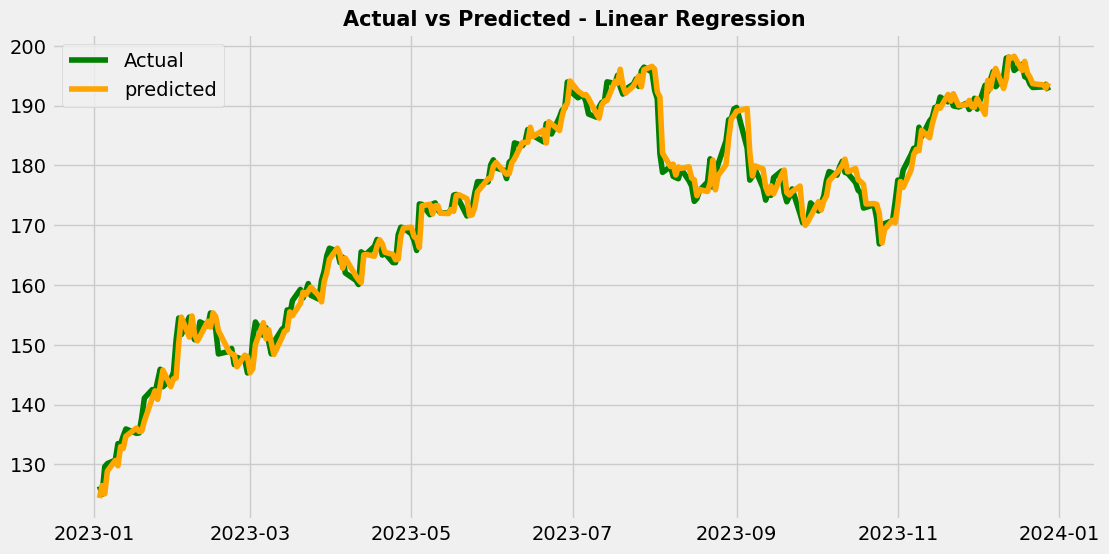

In [16]:
plotActualPred(df_test_preds,mName)
plt.show()

### Ridge Regression

In [17]:
model = Ridge(alpha=1.0,random_state=42)
model.fit(X_train,y_train)
#
pred=model.predict(X_test)
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_absolute_error(y_test,pred),2)
mae=np.round(mean_squared_error(y_test,pred),2)
mName="Ridge Regression"
print("R2",r2)
print("mae",mae)
print("mse",mse)
#
df_test_preds['pred']=pred
metric_vals.append([mName,r2,mae,mse])
df_test_preds.head()

R2 0.98
mae 5.44
mse 1.82


,y_true,pred
date,,
2023-01-03,126.360001,127.341599
2023-01-04,125.019997,127.265636
2023-01-05,129.619995,126.408790
2023-01-06,130.149994,128.419655
2023-01-09,130.729996,131.099598


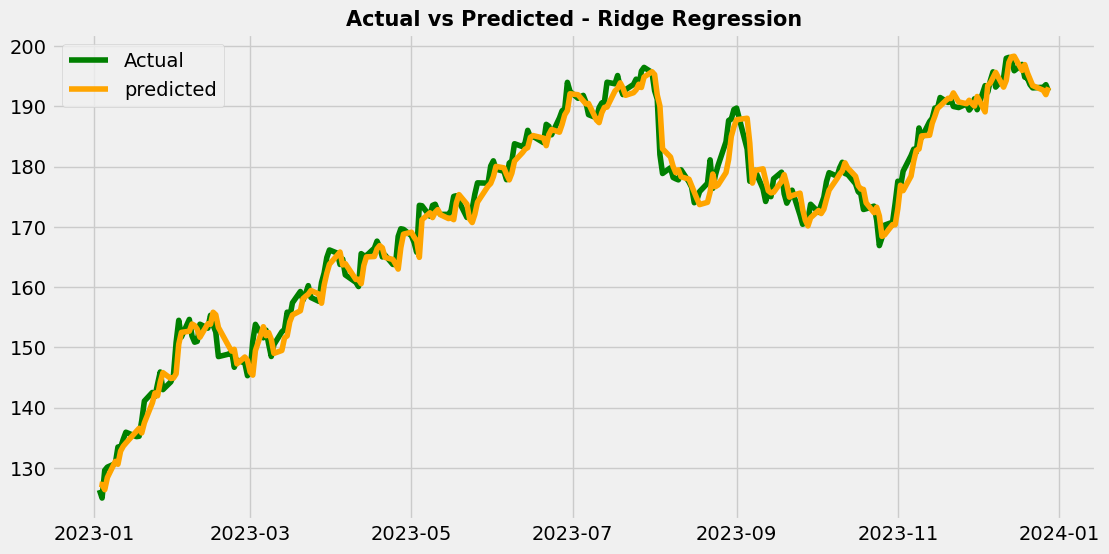

In [18]:
plotActualPred(df_test_preds,mName)
plt.show()

### Lasso Regression

In [19]:
model = Lasso(alpha=0.2,random_state=42)
model.fit(X_train,y_train)
#
pred=model.predict(X_test)
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_absolute_error(y_test,pred),2)
mae=np.round(mean_squared_error(y_test,pred),2)
mName="Lasso Regression"
print("R2",r2)
print("mae",mae)
print("mse",mse)
#
df_test_preds['pred']=pred
metric_vals.append([mName,r2,mae,mse])
df_test_preds.head()


R2 0.97
mae 8.74
mse 2.42


,y_true,pred
date,,
2023-01-03,126.360001,127.384424
2023-01-04,125.019997,126.755909
2023-01-05,129.619995,125.780536
2023-01-06,130.149994,128.816149
2023-01-09,130.729996,130.814080


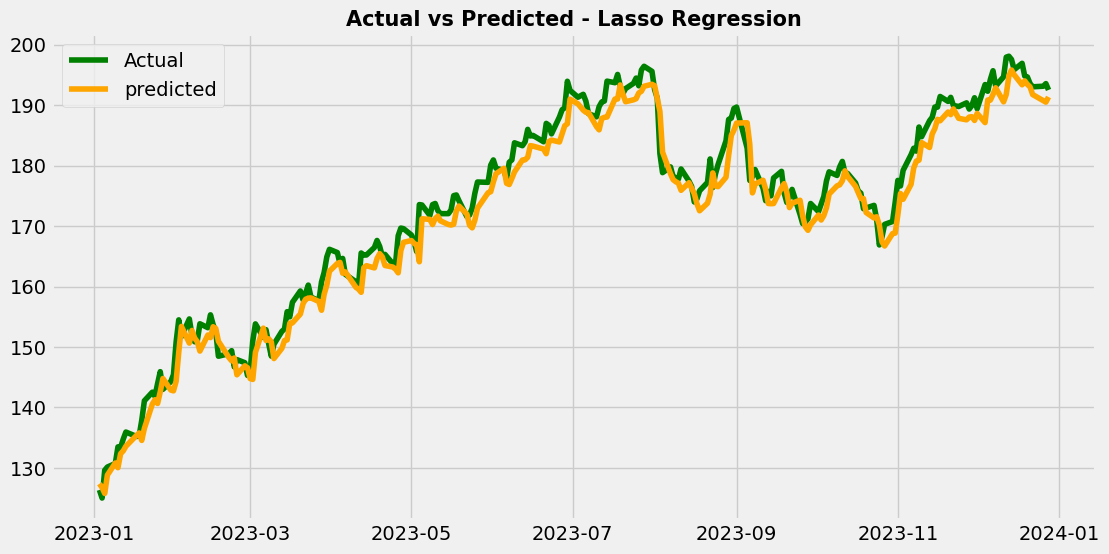

In [20]:
plotActualPred(df_test_preds,mName)
plt.show()

### ElasticNet Regression

In [21]:
model = ElasticNet(alpha=0.01,random_state=42)
model.fit(X_train,y_train)
#
pred=model.predict(X_test)
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_absolute_error(y_test,pred),2)
mae=np.round(mean_squared_error(y_test,pred),2)
mName="ElasticNet Regression"
print("R2",r2)
print("mae",mae)
print("mse",mse)
#
df_test_preds['pred']=pred
metric_vals.append([mName,r2,mae,mse])
df_test_preds.head()

R2 0.97
mae 9.29
mse 2.48


,y_true,pred
date,,
2023-01-03,126.360001,129.050684
2023-01-04,125.019997,128.561336
2023-01-05,129.619995,127.622517
2023-01-06,130.149994,129.851236
2023-01-09,130.729996,132.031304


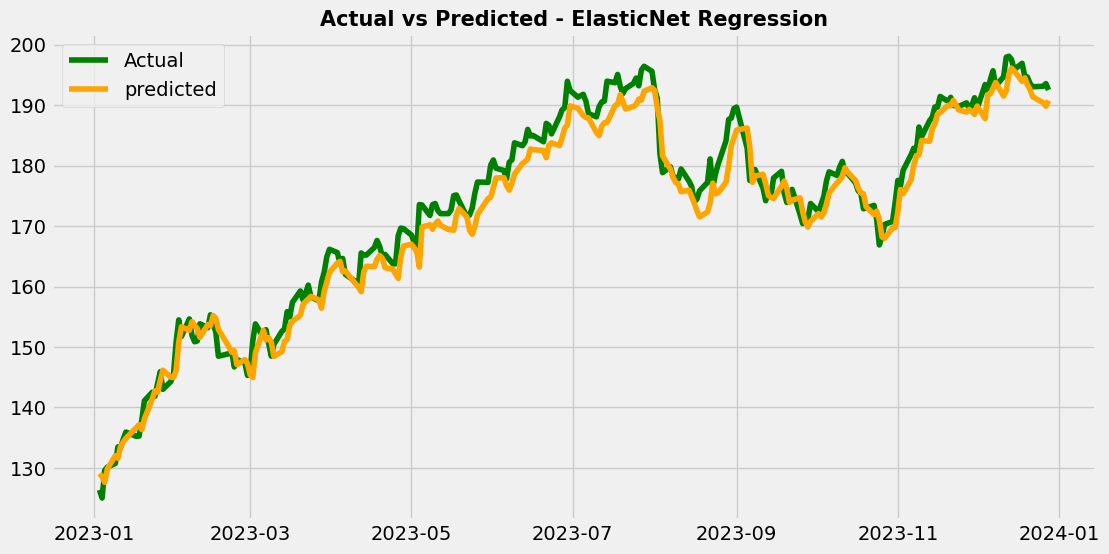

In [22]:
plotActualPred(df_test_preds,mName)
plt.show()

### Evaluation Metrics

In [23]:
df_metric=pd.DataFrame(metric_vals)
df_metric.columns=['Model','R2','MSE','MAE']
df_metric.head()

,Model,R2,MSE,MAE
0,Linear Regression,0.98,4.92,1.70
1,Ridge Regression,0.98,5.44,1.82
2,Lasso Regression,0.97,8.74,2.42
3,ElasticNet Regression,0.97,9.29,2.48
